In [1]:
!pip install transformers
!pip install datasets
!wget https://raw.githubusercontent.com/Gumgo91/Bioinfo1/main/project/data/binfo1-datapack1/dataset.csv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 76.1 MB/s 
     |████████████████████████████████| 86 kB 4.4 MB/s 
     |████████████████████████████████| 6.6 MB 55.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 346 kB 5.2 MB/s 
     |████████████████████████████████| 86 kB 7.7 MB/s 
     |████████████████████████████████| 212 kB 104.8 MB/s 
     |████████████████████████████████| 1.1 MB 86.5 MB/s 
     |████████████████████████████████| 140 kB 107.1 MB/s 
     |████████████████████████████████| 127 kB 86.8 MB/s 
     |████████████████████████████████| 144 kB 98.9 MB/s 
     |█████████████

In [2]:
# https://academic.oup.com/bioinformatics/article/37/15/2112/6128680
# DNA BERT for vectorization of sequences
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("armheb/DNA_bert_3")
model = AutoModelForSequenceClassification.from_pretrained("armheb/DNA_bert_3", num_labels=1)

Downloading:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/287 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of the model checkpoint at armheb/DNA_bert_3 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at armheb/DNA_bert_3 and are n

In [3]:
import pandas as pd

df = pd.read_csv('dataset.csv')
df

,seq,Y
0,GGGAAAAGGAAAGGGGGAAAAGAGGGAGCAAGGAGGGGAGGAGGAG...,1
1,CCCGGGGGGGGGCGGGGGGGGGGGGGGGCTCTGCCCCCCCGCCCGG...,1
2,CCCCCCCCCCCCCTTTCCCTTTTCTTCGGCGGGCCCCCCCCCCCTT...,1
3,GGGGGGGGGGGGGGGGGCGGCGCGGGGAGGAGAAGAAGAGGAAAAA...,1
4,GGGGGGGGGGGGGGGGGGAACCCCCCCGGGGGGGGGGGGGAAGAGG...,1
...,...,...
37655,CCGCTTGTAGCTTTGCATAGTGTCAGGATGTCAGCATGAGTGATCT...,0
37656,TGCAACCGGTTATTCCGCCCCTAGTCAAGCCCTAATAGTTACAGCG...,0
37657,CGACCCTAGCCCTCCAGGTACGGGAGCCACAACATGCGTAACTGCC...,0
37658,CAACAGCTTTCAACACGAATCGGATAAGTTGATGCGATTTGCACAC...,0


In [124]:
import regex as re
def kmer_indexing(seq):
    kmers = re.findall(r'\w{3}', seq, overlapped=True) # get overlapped 3-mer seq
    kmers = ' '.join(kmers)
    return tokenizer(kmers, truncation=True)['input_ids'] # indexing

x = list(map(kmer_indexing, df['seq']))
y = list(map(float, df['Y']))

In [64]:
# split train, test, valid datasets
from sklearn.model_selection import train_test_split
x_trainval, x_test, y_trainval, y_test = train_test_split(x, y, test_size=.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_trainval, y_trainval, test_size=.2, random_state=42)

In [65]:
from datasets import Dataset

train_dataset = Dataset.from_dict({"input_ids": x_train, "labels": y_train})
val_dataset = Dataset.from_dict({"input_ids": x_valid, "labels": y_valid})
test_dataset = Dataset.from_dict({"input_ids": x_test, "labels": y_test})

In [34]:
import torch
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

train_dataset = SequenceDataset(x_train, y_train)
val_dataset = SequenceDataset(x_valid, y_valid)
test_dataset = SequenceDataset(x_test, y_test)

In [69]:
# Train
from transformers import TrainingArguments
from transformers import Trainer
from transformers import DataCollatorWithPadding

from datasets import load_metric
metric = load_metric('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
training_args = TrainingArguments("test-trainer") # output dir

trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 24102
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9039


Step,Training Loss
500,0.002000
1000,0.001800
1500,0.003100
2000,0.003700
2500,0.001500
3000,0.000900
3500,0.000500
4000,0.001400
4500,0.002000
5000,0.001900


Saving model checkpoint to test-trainer/checkpoint-500
Configuration saved in test-trainer/checkpoint-500/config.json
Model weights saved in test-trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-500/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1000
Configuration saved in test-trainer/checkpoint-1000/config.json
Model weights saved in test-trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1500
Configuration saved in test-trainer/checkpoint-1500/config.json
Model weights saved in test-trainer/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1500/tokenizer_config.json
Special tokens file saved

TrainOutput(global_step=9039, training_loss=0.0013448033672036725, metrics={'train_runtime': 1142.2582, 'train_samples_per_second': 63.301, 'train_steps_per_second': 7.913, 'total_flos': 7628597083281684.0, 'train_loss': 0.0013448033672036725, 'epoch': 3.0})

In [99]:
import numpy as np

output = trainer.predict(test_dataset)
predictions = (torch.sigmoid(torch.tensor(output.predictions)) > 0.5) * 1.0
label_ids = output.label_ids
metrics = output.metrics

# 사용하고 싶은 metric 불러오기
metric = load_metric('accuracy')
metric.compute(predictions=predictions, references=label_ids) # Accuracy 0.994

***** Running Prediction *****
  Num examples = 7532
  Batch size = 8


{'accuracy': 0.9940254912373871}

In [41]:
# BERT pooler output을 이용해 시각화
from transformers import BertModel, AutoTokenizer
model2 = BertModel.from_pretrained("armheb/DNA_bert_3", add_pooling_layer = True)
tokenizer = AutoTokenizer.from_pretrained("armheb/DNA_bert_3")

import regex as re
def tsne_kmer_indexing(seq):
    kmers = re.findall(r'\w{3}', seq, overlapped=True)
    kmers = ' '.join(kmers)
    ids = tokenizer(kmers, truncation=True, return_tensors="pt")
    return model2(**ids)['pooler_output'].detach().numpy()

df_sample = df.sample(n=500)
tsne_x = list(map(tsne_kmer_indexing, df_sample['seq']))

Some weights of the model checkpoint at armheb/DNA_bert_3 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


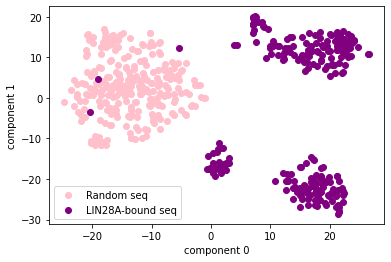

In [43]:
from sklearn.manifold import TSNE
import numpy as np

# 2차원 t-SNE 임베딩
tsne_np = TSNE(n_components = 2).fit_transform(np.array(tsne_x).reshape(500,768))

# numpy array -> DataFrame 변환
tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1'])
tsne_df['target'] = df_sample.reset_index()['Y']

# target 별 분리
tsne_df_0 = tsne_df[tsne_df['target'] == 0]
tsne_df_1 = tsne_df[tsne_df['target'] == 1]

# target 별 시각화
import matplotlib.pyplot as plt

plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color = 'pink', label = 'Random seq')
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color = 'purple', label = 'LIN28A-bound seq')
plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()